In [1]:
# import dependencies
from __future__ import division 
import numpy as np
import pandas as pd
import gc
import pickle
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Merge, TimeDistributed, Lambda, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers.advanced_activations import PReLU
from keras.preprocessing import sequence, text

from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization,maximum,concatenate,average,multiply,subtract
from keras.models import Model

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# import the preprocessed dataframe
import pickle
with open('question_pair.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
y = df.is_duplicate.values

In [4]:
tk = text.Tokenizer(num_words=200000)
# we use keras Tokenizer to tokenizer the data. 
# we will only consider top 200000 words that occur in the dataset

max_len = 30
# the maximum length of each sequence

tk.fit_on_texts(list(df.question1.values.astype(str)) + list(df.question2.values.astype(str)))

#we now convert the text to numerical data
x1 = tk.texts_to_sequences(df.question1.values.astype(str))
x2 = tk.texts_to_sequences(df.question2.values.astype(str))

# we pad the sequences so that all questions are of the same length(30)
x1 = sequence.pad_sequences(x1, maxlen=max_len)
x2 = sequence.pad_sequences(x2, maxlen=max_len)

#the word_index contains the words in our dataset mapped to numbers
word_index = tk.word_index

In [5]:
#split the dataset to train and test
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x1,x2,y, test_size = 0.1,random_state=2017)

In [6]:
#we import our pretrained weights for the words in our dataset. 
#This file was created during preprocessing
embedding_matrix = np.loadtxt('embeddings.txt')

In [7]:
#Just freeing up some ram, the next steps will consume a lot more
df=0
x1=0
x2=0
gc.collect()
embedding_matrix.shape

(88368, 300)

In [9]:
print('Build model...')


#ques1 and ques2 define our input dimensions
ques1 = Input(shape=(30,))
ques2 = Input(shape=(30,))

#q1 defines the standalone layers for question1 (1xEmbedding,1xTimeDistributed,1xLambda)

#initialize the embedding layer with pretrained glove embeddings. This layer is not trainable
#takes question1 vector as input
q1 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques1)
q1 = TimeDistributed(Dense(300, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(q1)

#q2 defines the standalone layesr for question2 (1xEmbedding,1xTimeDistributed,1xLambda)

#initialize the embedding layer with pretrained glove embeddings. This layer is not trainable
#takes question2 vector as input
q2 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques2)
q2 = TimeDistributed(Dense(300, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(q2)


# merge the models by substracting output of q2 from q1
merged = subtract([q1,q2])

# BatchNormalize the substraction results
merged = BatchNormalization()(merged)

#the Fully Connected Layers consisting of Dense layers with Dropouts and BatchNormalization
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)

#the final layer is a single output layer with sigmoid activation since we only need the 
#predicted probabilities for our binary classes

merged = Dense(1, activation='sigmoid')(merged)


# create the model with 2 inputs and single output
model = Model(inputs=[ques1,ques2], outputs=merged)

#checkpoint will help us save the model weights with best accuracy
checkpoint = ModelCheckpoint('real_merge_2.h5', monitor='val_acc', save_best_only=True, verbose=2)

#estop will help us stop the model when there is no improvement in 20 iterations
estop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='auto')

#compile the model with binary-crossentropy and adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#summary() function allows us to visualize the model architecture
model.summary()

Build model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 30, 300)       26510400    input_3[0][0]                    
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 30, 300)       26510400    input_4[0][0]                    
____________________________________________________________________________

In [16]:
#fit the model on training set and validate on 10% out of bag samples shuffled every iteration
model.fit([x1_train, x2_train], y=y_train, batch_size=500, epochs=100,
verbose=1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,estop])

Train on 327474 samples, validate on 36387 samples
Epoch 1/100
327474/327474 [==============================] - 19s - loss: 0.5701 - acc: 0.7016 - val_loss: 0.5240 - val_acc: 0.7314
Epoch 2/100
327474/327474 [==============================] - 19s - loss: 0.4709 - acc: 0.7712 - val_loss: 0.4568 - val_acc: 0.7783
Epoch 3/100
327474/327474 [==============================] - 19s - loss: 0.4235 - acc: 0.7989 - val_loss: 0.4240 - val_acc: 0.7944
Epoch 4/100
327474/327474 [==============================] - 19s - loss: 0.3907 - acc: 0.8187 - val_loss: 0.4002 - val_acc: 0.8098
Epoch 5/100
327474/327474 [==============================] - 21s - loss: 0.3665 - acc: 0.8317 - val_loss: 0.3939 - val_acc: 0.8147
Epoch 6/100
327474/327474 [==============================] - 22s - loss: 0.3462 - acc: 0.8432 - val_loss: 0.3909 - val_acc: 0.8204
Epoch 7/100
327474/327474 [==============================] - 21s - loss: 0.3290 - acc: 0.8522 - val_loss: 0.3902 - val_acc: 0.8172
Epoch 8/100
327474/327474 [=====

In [10]:
# we can load our saved weights using load_weights function
model.load_weights('real_merge_2.h5')

# find the predictions using predict(). This will output only the probability
preds  = model.predict([x1_train,x2_train])

# we need to convert our predicted probabilies to binary classes(0,1), since F1 score doesnot support probabilities
predicted_classes = np.zeros((preds.shape[0],1))
for i in range(len(preds)):
    if preds[i] >= 0.500:
        predicted_classes[i]=1
        
        
#using sklearn f1_score function to find the score        
print('F1 Score on train_set: '+ str(f1_score(y_train,predicted_classes)))

F1 Score on train_set: 0.917320899191


In [12]:
# we can load our saved weights using load_weights function
model.load_weights('real_merge_2.h5')


# find the predictions using predict(). This will output only the probability
preds  = model.predict([x1_test,x2_test])

# we need to convert our predicted probabilies to binary classes(0,1), since F1 score doesnot support probabilities
predicted_classes = np.zeros((preds.shape[0],1))
for i in range(len(preds)):
    if preds[i] >= 0.500:
        predicted_classes[i]=1
        
        
#using sklearn f1_score function to find the score        
print('F1 Score on test_set: '+ str(f1_score(y_test,predicted_classes)))

F1 Score on test_set: 0.774578959803


In [11]:
#evaluate() method automatically calculates the accuracy and logloss score
score, acc = model.evaluate([x1_test,x2_test],y_test)

40429/40429 [==============================] - 5s     


In [19]:
print'The Final Model Accuracy is: '+ str(acc)

The Final Model Accuracy is: 0.83479680428


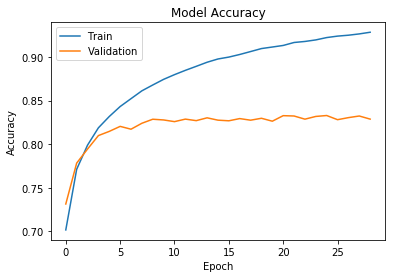

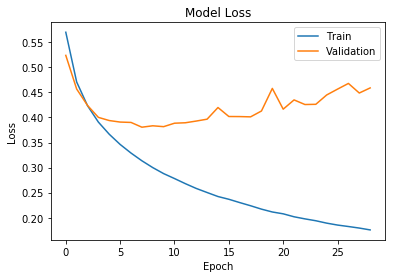

In [24]:
# Plot accuracy
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()